---
title: Detectors
authors: [gvarnavides]
date: 2025-02-01
---

In [16]:
# %matplotlib widget

import abtem
import ase
import numpy as np
import matplotlib.pyplot as plt

# import py4DSTEM
from scipy.ndimage import rotate

abtem.config.set({"dask.lazy":False});

## Atoms and Potential

In [17]:
srtio3_unit_cell = ase.io.read("data/SrTiO3.cif")
srtio3 = srtio3_unit_cell*(6,6,2)
gpts = (192,192)
scan_gpts = (32,32) # Double Nyquist later
energy = 200e3
semiangle_cutoff = 20

In [18]:
potential = abtem.Potential(
    srtio3,
    gpts=gpts,
    slice_thickness=srtio3.cell[2,2]/8,
    projection='finite'
).build(
)

In [19]:
probe_in_focus = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
).match_grid(
    potential
)

## Scans

In [20]:
custom_positions = srtio3_unit_cell.positions[:4,:2]
custom_scan = abtem.CustomScan(
    positions=custom_positions
)

In [21]:
line_scan = abtem.LineScan(
    start=(0,0),
    end=np.array(potential.extent)/6,
    gpts=scan_gpts[0]*4
)

In [22]:
grid_scan = abtem.GridScan(
    start=(0,0),
    end=np.array(potential.extent)/6,
    gpts=scan_gpts,
)

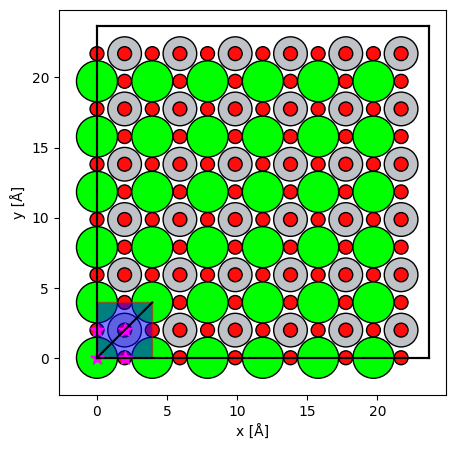

In [23]:
#| label: app:detectors_scans
fig,ax = plt.subplots(figsize=(5,5))
abtem.show_atoms(
    srtio3,
    ax=ax
)
grid_scan.add_to_plot(ax,alpha=0.5,facecolor='b')
line_scan.add_to_axes(ax,color='k')
ax.scatter(custom_positions[:,1],custom_positions[:,0],c='magenta',marker='*',s=100);

In [24]:
# exit_waves_custom = probe_in_focus.multislice(potential,scan=custom_scan)
exit_waves_line = probe_in_focus.multislice(potential,scan=line_scan)
exit_waves_grid = probe_in_focus.multislice(potential,scan=grid_scan)

## Monolithic Detectors

In [25]:
bright = abtem.AnnularDetector(inner=0, outer=25)
maadf = abtem.AnnularDetector(inner=25, outer=65)
haadf = abtem.AnnularDetector(inner=65, outer=100)

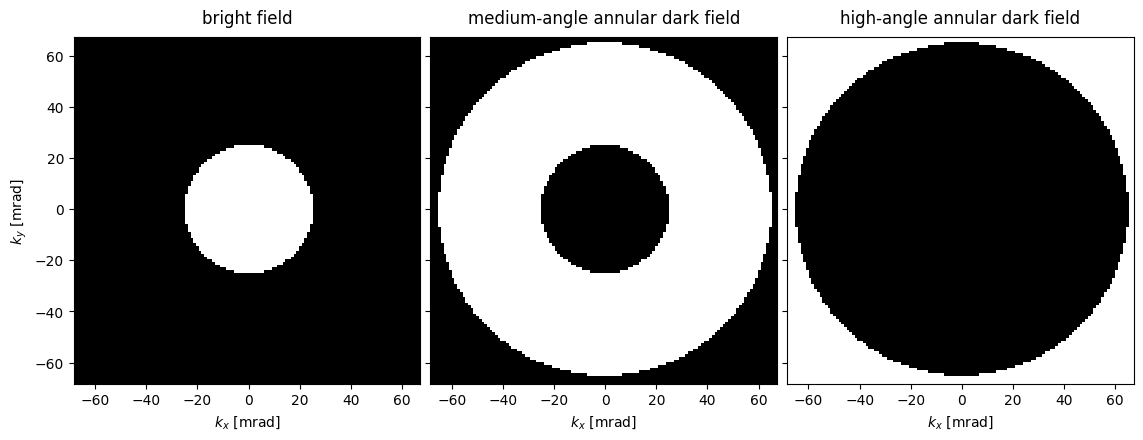

In [26]:
#| label: app:detectors_monolithic
bright_region = bright.get_detector_region(probe_in_focus)
maadf_region = maadf.get_detector_region(probe_in_focus)
haadf_region = haadf.get_detector_region(probe_in_focus)

labels = ("bright field", "medium-angle annular dark field", "high-angle annular dark field")
stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), labels
)

visualization = stacked_regions.show(
    explode=True,units="mrad", figsize=(12,4.5),
    cmap='gray'
)

## Measurements

In [27]:
line_measurement_bright = bright.detect(exit_waves_line)
line_measurement_maadf = maadf.detect(exit_waves_line)
line_measurement_haadf = haadf.detect(exit_waves_line)

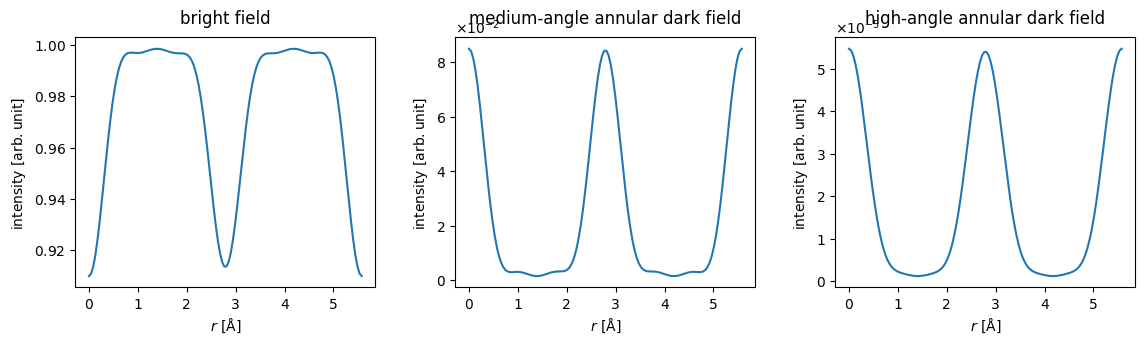

In [28]:
#| label: app:detectors_monolithic_line
line_measurements = abtem.stack(
    [
        line_measurement_bright,
        line_measurement_maadf,
        line_measurement_haadf
    ],
    labels
)

visualization = line_measurements.show(explode=True,common_scale=False, figsize=(12, 3))

In [29]:
grid_measurement_bright = bright.detect(exit_waves_grid)
grid_measurement_maadf = maadf.detect(exit_waves_grid)
grid_measurement_haadf = haadf.detect(exit_waves_grid)

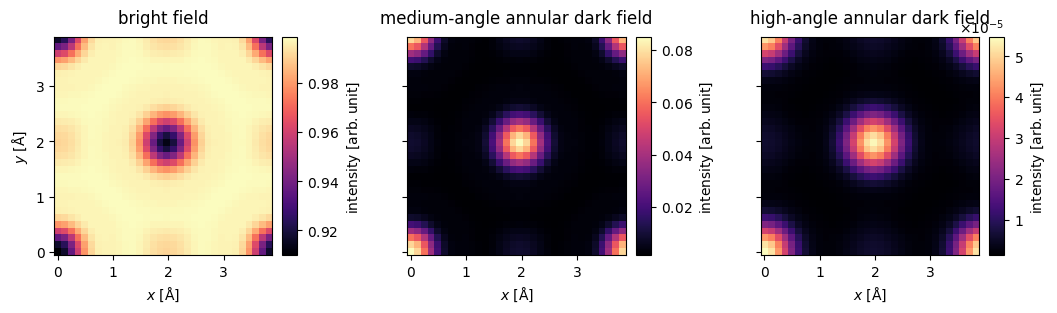

In [30]:
#| label: app:detectors_monolithic_grid
grid_measurements = abtem.stack(
    [
        grid_measurement_bright,
        grid_measurement_maadf,
        grid_measurement_haadf
    ],
    labels
)

visualization = grid_measurements.show(explode=True, cbar=True, figsize=(12, 3),cmap='magma')

## Pixelated Detectors

In [31]:
cropped_gpts = (gpts[0]//2,gpts[1]//2)

pixelated_detector = abtem.PixelatedDetector(max_angle=None)
grid_measurement_pixelated = pixelated_detector.detect(
    exit_waves_grid
).crop(
    gpts=(gpts[0]//2,gpts[1]//2)
)

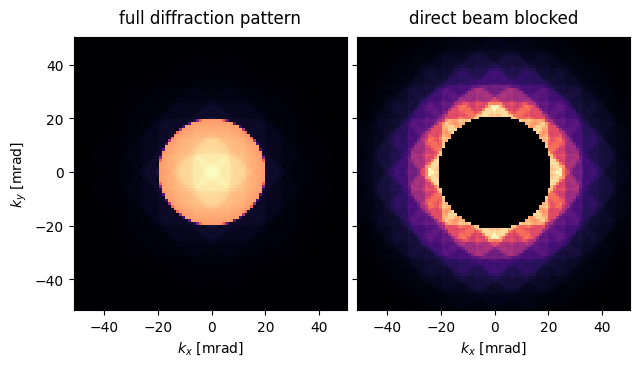

In [32]:
#| label: app:detectors_pixelated
abtem.stack(
    [
        grid_measurement_pixelated[0,0],
        grid_measurement_pixelated[0,0].block_direct()
    ],
    ("full diffraction pattern","direct beam blocked")
).show(
    explode=True,
    units="mrad",
    cmap='magma'
);

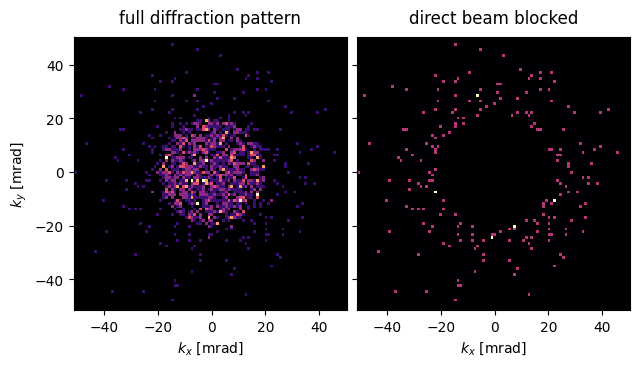

In [35]:
#| label: app:detectors_pixelated_postprocessed
grid_measurement_pixelated_postprocessed = grid_measurement_pixelated.copy()
grid_measurement_pixelated_postprocessed._array = rotate(
    grid_measurement_pixelated_postprocessed.array,
    angle = 15, #deg
    order=1,
    reshape=False,
    axes=(-1,-2)
).clip(0)

grid_measurement_pixelated_postprocessed = grid_measurement_pixelated_postprocessed.poisson_noise(
    dose_per_area=1e5
)

abtem.stack(
    [
        grid_measurement_pixelated_postprocessed[0,0],
        grid_measurement_pixelated_postprocessed[0,0].block_direct(radius=semiangle_cutoff+0.25)
    ],
    ("full diffraction pattern","direct beam blocked")
).show(
    explode=True,
    units="mrad",
    cmap='magma'
);

### Export for use in `12.1.direct-ptychography.ipynb`

In [19]:
# dc_in_focus = py4DSTEM.DataCube(grid_measurement_pixelated_postprocessed.array)
# dc_in_focus.calibration.set_Q_pixel_size(grid_measurement_pixelated_postprocessed.angular_sampling[0])
# dc_in_focus.calibration.set_R_pixel_size(grid_scan.sampling[0])
# dc_in_focus.calibration.set_Q_pixel_units('mrad')
# dc_in_focus.calibration.set_R_pixel_units('A')
# dc_in_focus.calibration

In [20]:
# probe_defocus = abtem.Probe(
#     semiangle_cutoff=semiangle_cutoff,
#     energy=energy,
#     C10=-100,
# ).match_grid(
#     potential
# )

# grid_measurement_pixelated_postprocessed_defocus = probe_defocus.multislice(
#     potential,
#     scan=grid_scan,
#     detectors=pixelated_detector
# ).crop(
#     gpts=(gpts[0]//2,gpts[1]//2)
# )

# grid_measurement_pixelated_postprocessed_defocus._array = rotate(
#     grid_measurement_pixelated_postprocessed_defocus.array,
#     angle = 15, #deg
#     order=1,
#     reshape=False,
#     axes=(-1,-2)
# ).clip(0)

# grid_measurement_pixelated_postprocessed_defocus = grid_measurement_pixelated_postprocessed_defocus.poisson_noise(
#     dose_per_area=1e5
# )

In [21]:
# probe_aberrated = abtem.Probe(
#     semiangle_cutoff=semiangle_cutoff,
#     energy=energy,
#     C10=-100,C23=10000,phi23=np.deg2rad(27.5),
# ).match_grid(
#     potential
# )

# grid_measurement_pixelated_postprocessed_aberrated = probe_aberrated.multislice(
#     potential,
#     scan=grid_scan,
#     detectors=pixelated_detector
# ).crop(
#     gpts=(gpts[0]//2,gpts[1]//2)
# )

# grid_measurement_pixelated_postprocessed_aberrated._array = rotate(
#     grid_measurement_pixelated_postprocessed_aberrated.array,
#     angle = 15, #deg
#     order=1,
#     reshape=False,
#     axes=(-1,-2)
# ).clip(0)

# grid_measurement_pixelated_postprocessed_aberrated = grid_measurement_pixelated_postprocessed_aberrated.poisson_noise(
#     dose_per_area=1e5
# )

In [22]:
# dc_defocus = py4DSTEM.DataCube(grid_measurement_pixelated_postprocessed_defocus.array,calibration=dc_in_focus.calibration.copy())
# dc_aberrated = py4DSTEM.DataCube(grid_measurement_pixelated_postprocessed_aberrated.array,calibration=dc_in_focus.calibration.copy())

In [23]:
# py4DSTEM.save("data/dpc_STO_simulation_in-focus_1e5.h5",dc_in_focus,mode='o')
# py4DSTEM.save("data/dpc_STO_simulation_defocus_1e5.h5",dc_defocus,mode='o')
# py4DSTEM.save("data/dpc_STO_simulation_aberrated_1e5.h5",dc_aberrated,mode='o')